In [1]:
import numpy as np
import sklearn
import os
import pandas as pd
import typing as tp
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(rc={'figure.figsize': (8.25, 5.875), 'figure.dpi': 100, 'axes.labelpad': 2, 'savefig.pad_inches': .5})

In [2]:
from sklearn.cluster import KMeans, BisectingKMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import fowlkes_mallows_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs, load_iris, load_wine, fetch_openml
from sklearn.preprocessing import StandardScaler

In [3]:
wine_x, wine_y = load_wine(as_frame=False, return_X_y=True)
iris_x, iris_y = load_iris(return_X_y=True)
blob_x, blob_y = make_blobs(n_samples=1_000, n_features=2, centers=5, random_state=13, center_box=(-50, 50))
mnist_x, mnist_y = fetch_openml(data_id=554, return_X_y=True)

mnist_x = mnist_x.values
mnist_y = mnist_y.values

mnist_x, _, mnist_y, _ = train_test_split(mnist_x, mnist_y, train_size=.25, random_state=13, shuffle=True)

In [4]:
num_wine_classes: int = np.unique(wine_y).size
num_iris_classes: int = np.unique(iris_y).size
num_blob_classes: int = np.unique(blob_y).size
num_mnist_classes: int = np.unique(mnist_y).size

num_wine_classes, num_iris_classes, num_blob_classes, num_mnist_classes

(3, 3, 5, 10)

In [5]:
wine_x[0, :], iris_x[0, :], blob_x[0, :]
# cool all of them are numerical and thus we can use the standard deviation way.

(array([1.423e+01, 1.710e+00, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00,
        3.060e+00, 2.800e-01, 2.290e+00, 5.640e+00, 1.040e+00, 3.920e+00,
        1.065e+03]),
 array([5.1, 3.5, 1.4, 0.2]),
 array([15.15241248, 20.93095631]))

In [6]:
def category_utility(X: np.ndarray, y_pred: np.ndarray, acuity: float = 1) -> float:
    # Page 40 of Gennari, Langley, Fisher's Models of Incremental Concept Formulation
    # recommends an acuity value of 1
    # https://www.sciencedirect.com/science/article/pii/0004370289900465?ref=cra_js_challenge&fr=RR-1
    num_clusters: int = np.unique(y_pred).size

    prob_clusters: np.ndarray = np.unique(y_pred, return_counts=True)[1] / y_pred.size
    overall_feature_std: np.ndarray = X.std(axis=0)

    overall_feature_std[np.logical_or(np.isnan(overall_feature_std),
                                  np.logical_or(np.isinf(overall_feature_std), overall_feature_std <= 0))] = acuity
    inv_overall_feature_std: np.ndarray = 1 / overall_feature_std
    inv_overall_feature_std[overall_feature_std <= acuity] = acuity

    norm: float = 1 / np.sqrt(np.pi)

    cluster_cu: np.ndarray = np.zeros((num_clusters,))

    for k in range(num_clusters):
        prob_cluster_k: float = prob_clusters[k]

        cluster_k: np.ndarray = X[y_pred == k, :]

        conditional_feature_std: np.ndarray = cluster_k.std(axis=0)

        conditional_feature_std[np.logical_or(np.isnan(conditional_feature_std),
                                          np.logical_or(np.isinf(conditional_feature_std),
                                                        conditional_feature_std <= 0))] = acuity

        inv_conditional_feature_std: np.ndarray = 1 / conditional_feature_std
        inv_conditional_feature_std[conditional_feature_std <= acuity] = acuity


        diff_std: np.ndarray = np.abs(inv_overall_feature_std - inv_conditional_feature_std)

        cluster_cu[k] = prob_cluster_k * norm * np.sum(diff_std)

    overall_category_utility: float =  1 / num_clusters * np.sum(cluster_cu)
    return overall_category_utility

In [7]:
def create_kmeans_model(num_clusters: int) -> KMeans:
    return KMeans(n_clusters=num_clusters, init='k-means++', random_state=13)

def create_spectral_model(num_clusters: int) -> SpectralClustering:
    return SpectralClustering(n_clusters=num_clusters, random_state=13, assign_labels='cluster_qr', eigen_solver='amg', n_jobs=2)

def create_agglomerative_model(num_clusters: int) -> AgglomerativeClustering:
    return AgglomerativeClustering(n_clusters=num_clusters)

def create_bisect_kmeans_model(num_clusters: int) -> BisectingKMeans:
    return BisectingKMeans(n_clusters=num_clusters, random_state=13, bisecting_strategy='largest_cluster')

In [8]:
MAX_CLUSTERS: int = 20

datasets: tp.List[tp.Tuple[str, int, np.ndarray, np.ndarray]] = [('Wine', num_wine_classes, wine_x, wine_y), ('Iris', num_iris_classes, iris_x, iris_y), ('Blobs', num_blob_classes, blob_x, blob_y), ('MNIST', num_mnist_classes, mnist_x, mnist_y)]

models: tp.List[tp.Tuple[str, tp.Any]] = [('K-Means++' ,create_kmeans_model), ('Spectral', create_spectral_model), ('Agglomerative', create_agglomerative_model), ('Bisecting K-Means', create_bisect_kmeans_model)]

results_dl: tp.List[tp.Dict[str, tp.Union[float, str, int]]] = []

for model_name, model_function in models:
    for dataset_name, dataset_classes, x, y in datasets:

        for k in range(2, MAX_CLUSTERS):
            model = model_function(k)

            print(f'Trying out {dataset_name} with a {model_name} model...')

            # std_scaler: StandardScaler = StandardScaler()
            # scaled_x: np.ndarray = std_scaler.fit_transform(x)

            y_pred: np.ndarray = model.fit_predict(x)

            print('Getting scores')
            fm_score: float = fowlkes_mallows_score(y, y_pred)
            db_score: float = davies_bouldin_score(x, y_pred)

            print('Getting cu')
            cu: float = category_utility(x, y_pred) #  category_utility(X_test, y_pred, k)

            results_dl.append({'model_name': model_name, 'dataset_name': dataset_name, 'num_clusters': k, 'true_num_clusters': dataset_classes, 'fowlkes_mallows_score': fm_score, 'davies_bouldin_score': db_score, 'category_utility': cu})

results_df: pd.DataFrame = pd.DataFrame.from_records(results_dl)
results_df['matches_clusters'] = results_df['num_clusters'] == results_df['true_num_clusters']
results_df

Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Gettin

/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Wine with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Wine with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site

Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site

Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out MNIST with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative m

,model_name,dataset_name,num_clusters,true_num_clusters,fowlkes_mallows_score,davies_bouldin_score,category_utility,matches_clusters
0,K-Means++,Wine,2,3,0.659051,0.478784,0.070879,False
1,K-Means++,Wine,3,3,0.583537,0.534243,0.050983,True
2,K-Means++,Wine,4,3,0.516389,0.544401,0.043712,False
3,K-Means++,Wine,5,3,0.508708,0.545047,0.037230,False
4,K-Means++,Wine,6,3,0.491180,0.465807,0.033530,False
...,...,...,...,...,...,...,...,...
283,Bisecting K-Means,MNIST,15,10,0.336509,3.382370,3.944688,False
284,Bisecting K-Means,MNIST,16,10,0.306715,3.333554,3.780214,False
285,Bisecting K-Means,MNIST,17,10,0.311208,3.291172,3.661401,False
286,Bisecting K-Means,MNIST,18,10,0.315982,3.225165,3.530943,False


In [9]:
results_df.describe()

,num_clusters,true_num_clusters,fowlkes_mallows_score,davies_bouldin_score,category_utility
count,288.000000,288.000000,288.000000,288.000000,288.000000
mean,10.500000,5.250000,0.492816,7.667053,1.299028
std,5.197158,2.866361,0.206055,20.924397,2.483456
min,2.000000,3.000000,0.074251,0.124593,0.009048
25%,6.000000,3.000000,0.337635,0.632575,0.023185
50%,10.500000,4.000000,0.486019,1.027643,0.060880
75%,15.000000,6.250000,0.619217,3.013004,0.486363
max,19.000000,10.000000,1.000000,132.773513,11.937490


In [23]:
results_df.to_csv(os.path.join('.', 'results.csv'))

In [10]:
results_df.groupby(['model_name', 'matches_clusters']).aggregate({'category_utility': ['max', 'min'], 'fowlkes_mallows_score': ['max', 'min']})

category_utility            \
                                                max       min   
model_name        matches_clusters                              
Agglomerative     False                   11.937490  0.012817   
                  True                     6.845171  0.049434   
Bisecting K-Means False                    7.599677  0.012817   
                  True                     4.847698  0.049919   
K-Means++         False                    8.788671  0.012817   
                  True                     5.928566  0.050983   
Spectral          False                    3.515197  0.009048   
                  True                     1.715000  0.022581   

                                   fowlkes_mallows_score            
                                                     max       min  
model_name        matches_clusters                                  
Agglomerative     False                         0.949313  0.258777  
                  True                          1.000000  0.577864  
Bisecting K-Means False                         0.948440  0.264654  
                  True                          1.000000  0.336250  
K-Means++         False                         0.948609  0.250735  
                  True                          1.000000  0.434734  
Spectral          False                         0.948503  0.074251  
                  True                          1.000000  0.102745

<AxesSubplot:xlabel='model_name', ylabel='category_utility'>

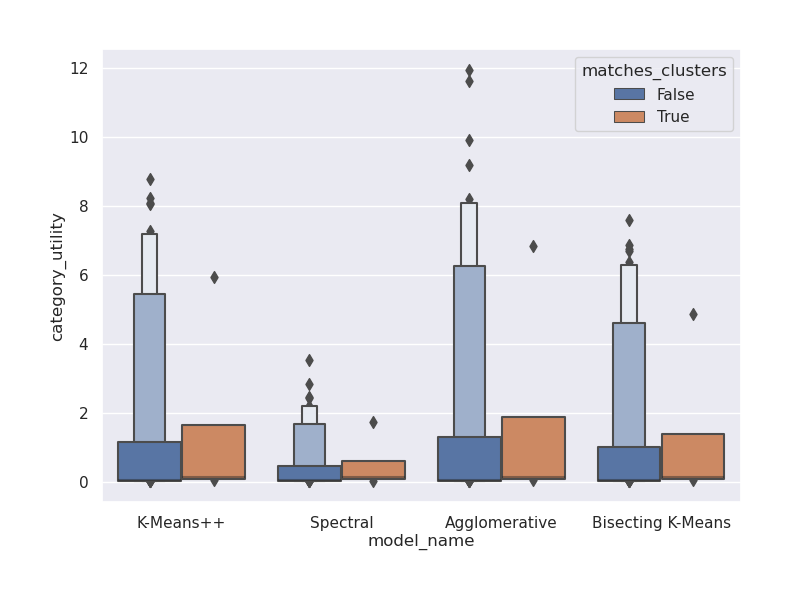

In [11]:
sns.boxenplot(data=results_df, x='model_name', y='category_utility', hue='matches_clusters')

<AxesSubplot:xlabel='model_name', ylabel='fowlkes_mallows_score'>

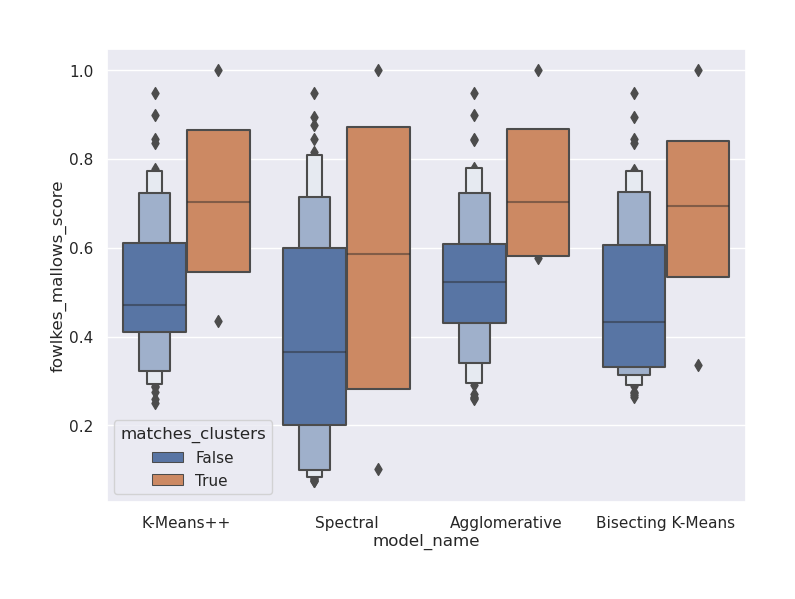

In [12]:
sns.boxenplot(data=results_df, x='model_name', y='fowlkes_mallows_score', hue='matches_clusters')

<AxesSubplot:xlabel='model_name', ylabel='davies_bouldin_score'>

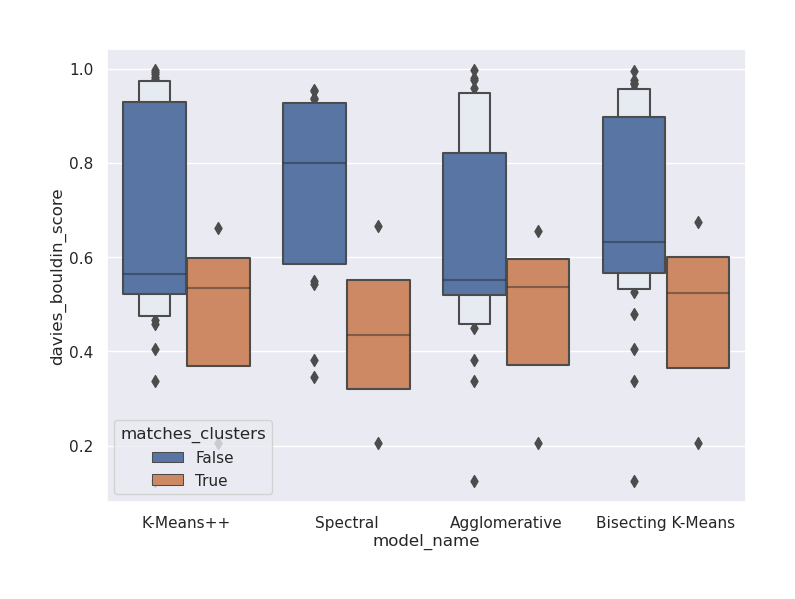

In [13]:
sns.boxenplot(data=results_df[results_df['davies_bouldin_score'] < 1], x='model_name', y='davies_bouldin_score', hue='matches_clusters')

So while category utility won't always predict the best number of clusters, the other metrics won't either

In [14]:
def compare_metrics(base_df: pd.DataFrame, metric_name: str) -> pd.DataFrame:
    grouped_comparison_df: pd.DataFrame = (base_df.groupby(['model_name', 'dataset_name', 'matches_clusters'], as_index=True)
                                           .aggregate({metric_name: lambda g: g.values.tolist()}, axis=0)
                                           .explode(metric_name, ignore_index=False))
    model_dataset_index: pd.MultiIndex = grouped_comparison_df.index.droplevel('matches_clusters').drop_duplicates()

    comparison_dl: tp.List[tp.Dict[str, tp.Any]] = []

    for model_name, dataset_name in model_dataset_index:
        mismatch_clusters: pd.Series = grouped_comparison_df.loc[(model_name, dataset_name, False), metric_name].copy()
        matched_clusters_metric: float = grouped_comparison_df.loc[(model_name, dataset_name, True), metric_name].values.item()

        num_better_mismatched: int = (mismatch_clusters > matched_clusters_metric).sum()

        # Store the model and dataset
        # The total num's + 1 is for when the clusters matched.
        # num_better is for the number of times the model got a better metric with the wrong number of clusters than
        # the metric with the correct number of clusters.
        comparison_dl.append({'model': model_name, 'dataset': dataset_name, 'total_num': mismatch_clusters.size + 1, 'num_better': num_better_mismatched})

    comparison_df: pd.DataFrame = pd.DataFrame.from_records(comparison_dl)
    return comparison_df

In [15]:
results_df

,model_name,dataset_name,num_clusters,true_num_clusters,fowlkes_mallows_score,davies_bouldin_score,category_utility,matches_clusters
0,K-Means++,Wine,2,3,0.659051,0.478784,0.070879,False
1,K-Means++,Wine,3,3,0.583537,0.534243,0.050983,True
2,K-Means++,Wine,4,3,0.516389,0.544401,0.043712,False
3,K-Means++,Wine,5,3,0.508708,0.545047,0.037230,False
4,K-Means++,Wine,6,3,0.491180,0.465807,0.033530,False
...,...,...,...,...,...,...,...,...
283,Bisecting K-Means,MNIST,15,10,0.336509,3.382370,3.944688,False
284,Bisecting K-Means,MNIST,16,10,0.306715,3.333554,3.780214,False
285,Bisecting K-Means,MNIST,17,10,0.311208,3.291172,3.661401,False
286,Bisecting K-Means,MNIST,18,10,0.315982,3.225165,3.530943,False


In [16]:
category_utility_comparison_df: pd.DataFrame = compare_metrics(results_df, 'category_utility')
# : db_score,
fowlkes_mallows_comparison_df: pd.DataFrame = compare_metrics(results_df, 'fowlkes_mallows_score')
davies_bouldin_comparison_df: pd.DataFrame = compare_metrics(results_df, 'davies_bouldin_score')
davies_bouldin_comparison_df['num_better'] = davies_bouldin_comparison_df['total_num'] - davies_bouldin_comparison_df['num_better']

/tmp/ipykernel_18876/2129213908.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


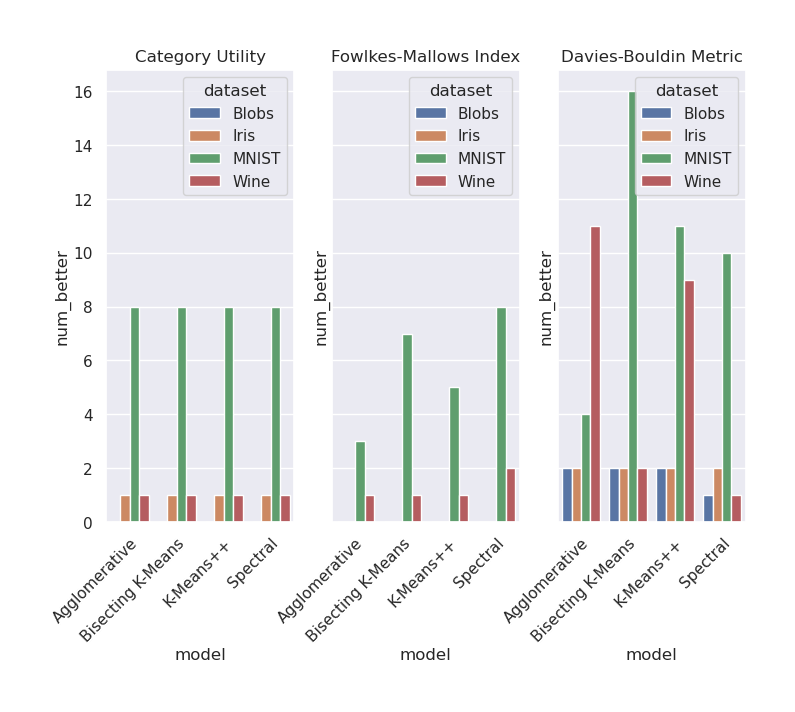

In [17]:
fig, axes = plt.subplots(1, 3, sharey=True)

# fig.title(f'Comparison of Metrics | Number of Mismatched # of Clusters')

sns.barplot(data=category_utility_comparison_df, x='model', y='num_better', hue='dataset', ax=axes[0])
axes[0].set_title('Category Utility')
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

sns.barplot(data=fowlkes_mallows_comparison_df, x='model', y='num_better', hue='dataset', ax=axes[1])
axes[1].set_title('Fowlkes-Mallows Index')
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

sns.barplot(data=davies_bouldin_comparison_df, x='model', y='num_better', hue='dataset', ax=axes[2])
axes[2].set_title('Davies-Bouldin Metric')
plt.setp(axes[2].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.show()

Text(0, 0.5, 'Counts')

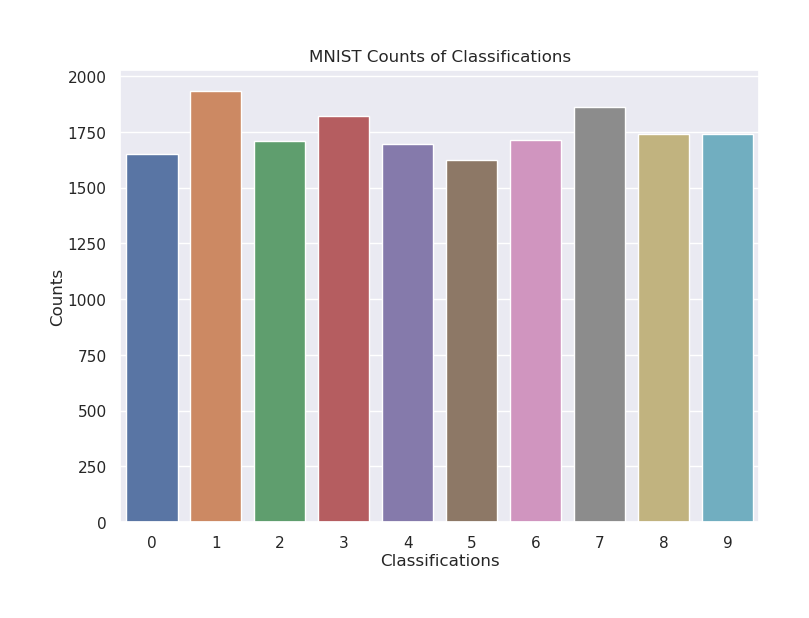

In [25]:
mnist_y_values, mnist_y_dist = np.unique(mnist_y, return_counts=True)
sns.barplot(x=mnist_y_values, y=mnist_y_dist)
plt.title('MNIST Counts of Classifications')
plt.xlabel('Classifications')
plt.ylabel('Counts')

<AxesSubplot:xlabel='model', ylabel='num_better'>

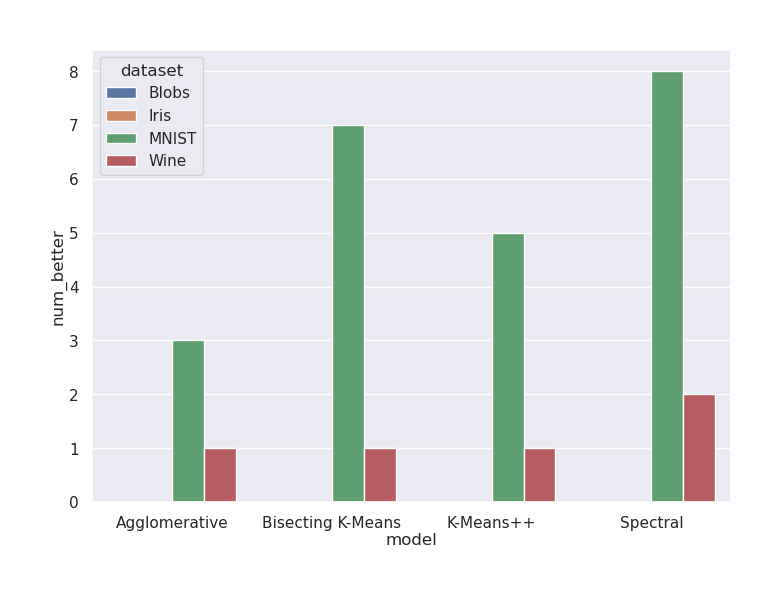

In [18]:
# Measures how close the prediction is to the truth data.
sns.barplot(data=fowlkes_mallows_comparison_df, x='model', y='num_better', hue='dataset')

<AxesSubplot:xlabel='model', ylabel='num_better'>

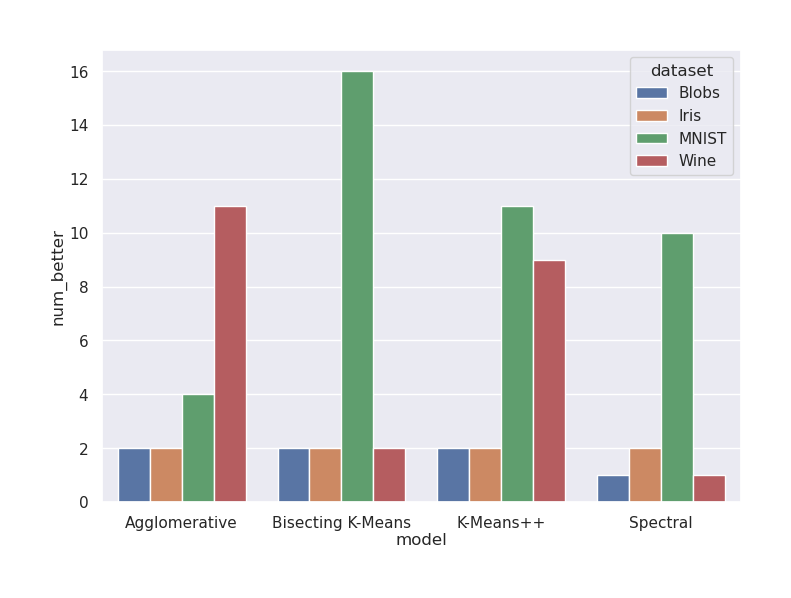

In [19]:
# Davies-Bouldin measures the classic clustering goal -
# everything within a cluster tightly knit and all of them are
# separated from each other.
sns.barplot(data=davies_bouldin_comparison_df, x='model', y='num_better', hue='dataset')

<AxesSubplot:>

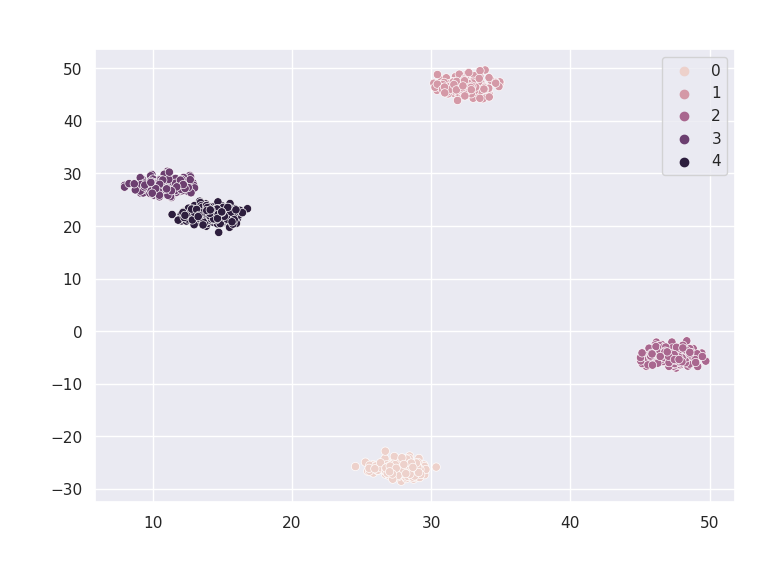

In [20]:
sns.scatterplot(x=blob_x[:, 0], y=blob_x[:, 1], hue=blob_y)

In [21]:
np.unique(blob_y)

array([0, 1, 2, 3, 4])

In [22]:
blob_x.shape

(1000, 2)